In [72]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from scipy.stats import multivariate_normal
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

xs = np.arange(0, 200, 1)

# Задание 1

In [73]:
data = pd.read_csv('owid-covid-data.csv')

In [74]:
Russia = data[data['location']=='Russia'][['date','new_cases','total_cases']]

In [75]:
Russia = Russia[pd.to_datetime(Russia['date']) >= pd.to_datetime('2020-03-03')]

# Задание 2

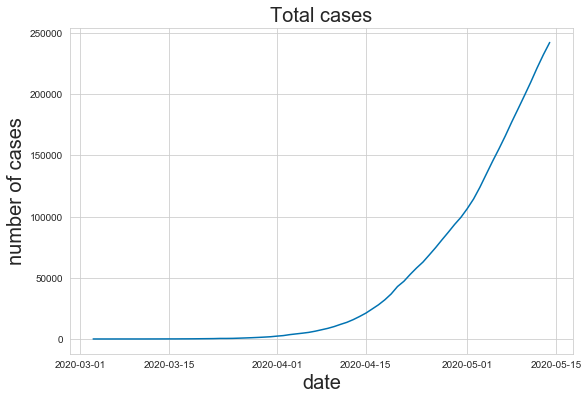

In [76]:
plt.figure(figsize=(9,6))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),Russia['total_cases']);

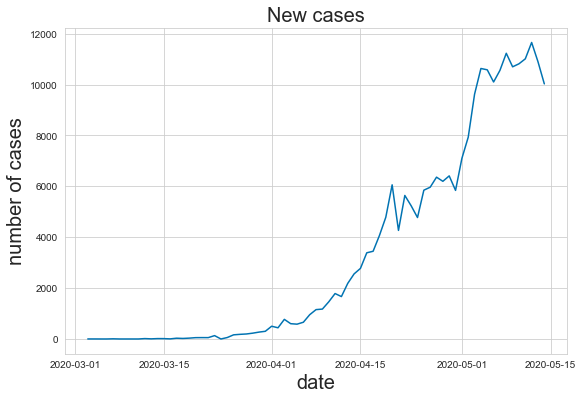

In [77]:
plt.figure(figsize=(9,6))
plt.title('New cases',fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),Russia['new_cases']);

In [78]:
train = Russia[:50]
test = Russia[50:]

## Пункты A, B, C

In [79]:
y_train = np.log(train['total_cases'])
y_test = np.log(test['total_cases'])
X_train = pd.to_datetime(train['date'])-pd.to_datetime('2020-03-03')
X_train = np.array([X_train.apply(lambda x: x.days)]).T
X_test = pd.to_datetime(test['date'])-pd.to_datetime('2020-03-03')
X_test = np.array([X_test.apply(lambda x: x.days)]).T
X_all = np.concatenate([X_train,X_test], axis = 0)
y_all = np.concatenate([y_train,y_test], axis = 0)

linear_regression = LinearRegression().fit(X_train,y_train)

MSE train: 0.128772948328438
MSE test: 5.505196378886351
MSE train (in terms of exp):  89876671.94553281
MSE test (in terms of exp):  12034676639488.834


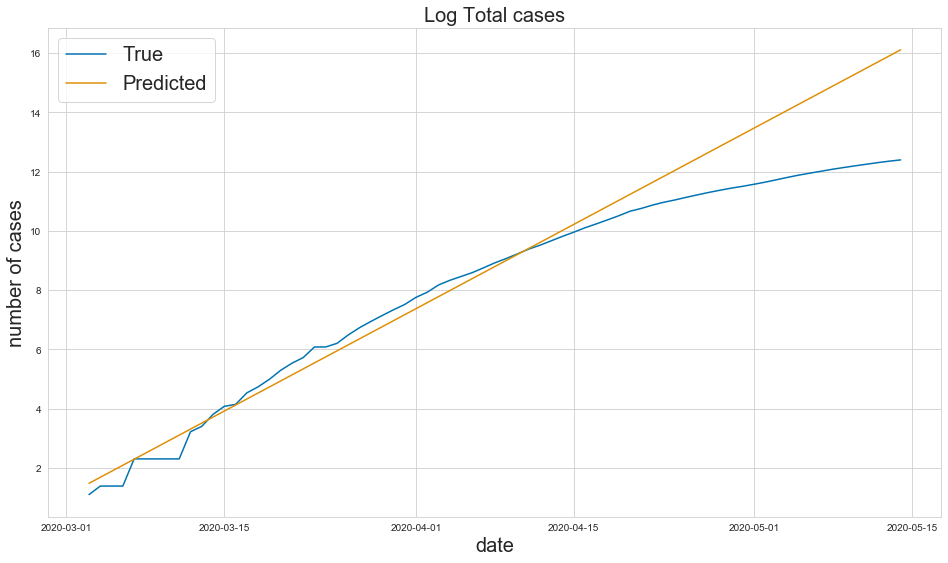

In [80]:
print('MSE train:',mse(linear_regression.predict(X_train),y_train))
print('MSE test:',mse(linear_regression.predict(X_test),y_test))
print('MSE train (in terms of exp): ', mse(np.exp(linear_regression.predict(X_train)),np.exp(y_train)))
print('MSE test (in terms of exp): ', mse(np.exp(linear_regression.predict(X_test)),np.exp(y_test)))
plt.figure(figsize=(16,9))
plt.title('Log Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),np.log(Russia['total_cases']), label = 'True');
plt.plot(pd.to_datetime(Russia['date']),linear_regression.predict(X_all), label = 'Predicted')
plt.legend(fontsize = 20);

In [81]:
N = 250
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

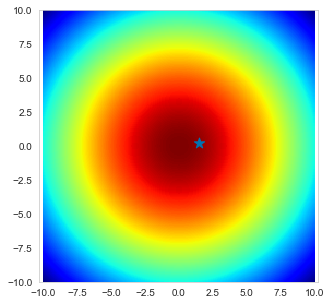

In [82]:
sigma = np.sqrt(mse(linear_regression.predict(X_train),y_train))
w_1 = linear_regression.coef_[0]
w_0 = linear_regression.intercept_

def myplot_heatmap(Z, print_point = True):
    # Make the plot
    plt.axis('equal')
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    if print_point:
        plt.scatter(w_0, w_1, marker='*', s=120)

# априорное распределение параметров w 
cur_mu, cur_sigma = np.array([0, 0]), np.array([[100, 0], [0, 100]])
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=(5, 5))
myplot_heatmap(Z)

In [83]:
def bayesian_update(mu, sigma, x, y, sigma_noise = sigma):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2))\
                     * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые экспоненты
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    plt.ylim((-0.01, 100000))
    plt.xlim((-0.01, 50))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

def plot_predictions(xs, mu, x):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((-0.01, 100))
    ax.set_ylim((-0.01, 100000))
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - sigma), np.exp(mu[1]*xs + mu[0] + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.exp(np.mean(x, axis=0) - np.std(x, axis=0)), np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

mu: 
 [1.09757024 0.28835281]
sigma: 
 [[ 0.12844236 -0.12827718]
 [-0.12827718  0.25671954]]


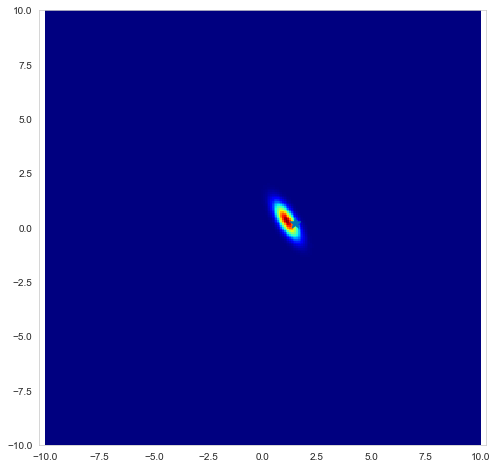

In [84]:
# сделаем пару bayes_update
mu_n, sigma_n = cur_mu, cur_sigma
for i in range(2):
    mu_n, sigma_n = bayesian_update(mu_n, sigma_n, X_train[:,0][i],\
                                    y_train.to_numpy()[i])
    
print('mu: \n',mu_n)
print('sigma: \n',sigma_n)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# апостериорное распределение параметров (при первых 2ух точках)
Z = multivariate_normal.pdf(pos, mean = mu_n, cov = sigma_n) 
myplot_heatmap(Z, True)

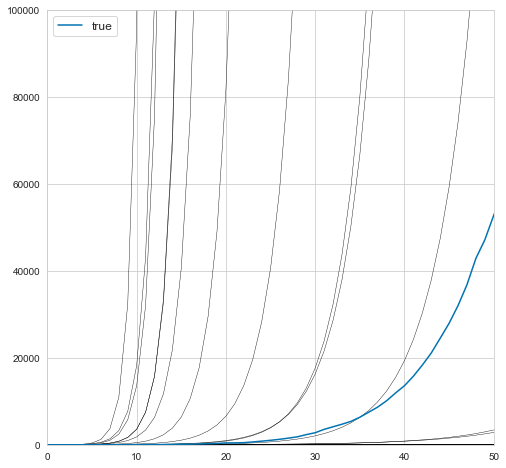

In [85]:
# посемплируем и посмотрим что получется
plt.figure(figsize = (8,8))
myplot_sample_lines(mu_n, sigma_n, n=20, points=None)
plt.plot(np.arange(len(Russia)),Russia['total_cases'], label = 'true')
plt.legend(fontsize = 'large')

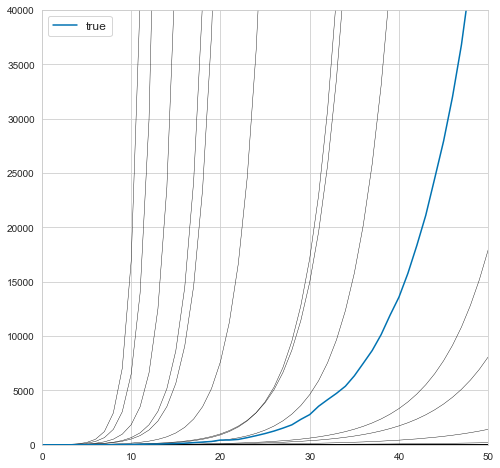

In [86]:
# стоит судить конечно стоит по обучающей выборке того, что мы делаем
plt.figure(figsize = (8,8))
myplot_sample_lines(mu_n, sigma_n, n=20, points=None)
plt.ylim(-0.01,40000)
plt.plot(X_train[:,0],np.exp(y_train), label = 'true')
plt.legend(fontsize = 'large')

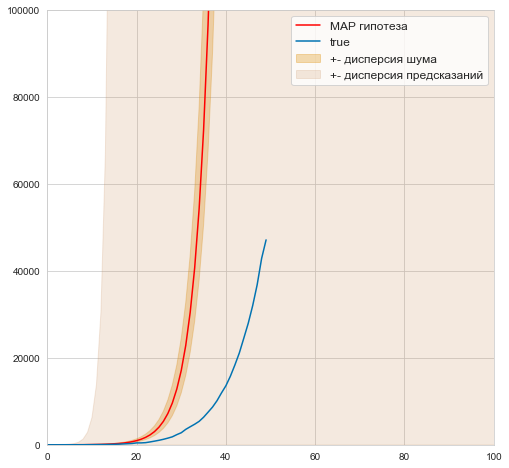

In [87]:
plot_predictions(xs, mu_n, sample_statistics(mu_n, sigma_n, xs, n=1000))
plt.plot(X_train[:,0],np.exp(y_train), label = 'true')
plt.legend(fontsize = 'large')

In [88]:
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

mu: 
 [1.47880932 0.20328483]
sigma: 
 [[ 9.99784011e-03 -3.02964842e-04]
 [-3.02964842e-04  1.23662304e-05]]


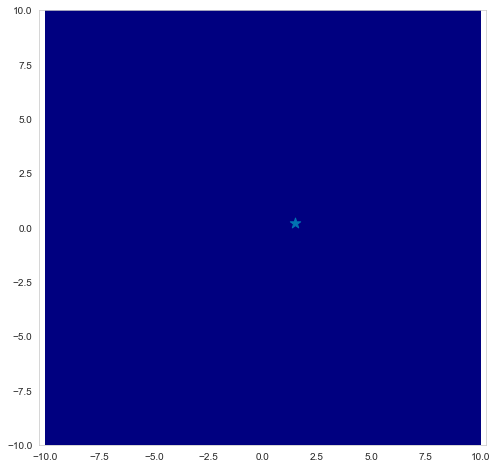

In [89]:
mu_n, sigma_n = cur_mu, cur_sigma
for i in range(len(y_train)):
    mu_n, sigma_n = bayesian_update(mu_n, sigma_n, X_train[:,0][i],\
                                    y_train.to_numpy()[i])
    
print('mu: \n',mu_n)
print('sigma: \n',sigma_n)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# апостериорное распределение параметров (при всех данных)
Z = multivariate_normal.pdf(pos, mean = mu_n, cov = sigma_n) 
myplot_heatmap(Z, True)
# дисперсия очень маленькая потому звездочка накрыла купол гауссианы (собственные значения дисперсии малы => накрытие)

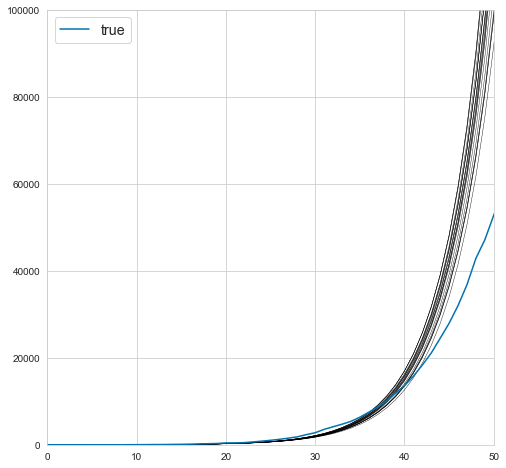

In [90]:
plt.figure(figsize = (8,8))
myplot_sample_lines(mu_n, sigma_n, n=20, points=None)
plt.plot(np.arange(len(Russia)),Russia['total_cases'], label = 'true')
plt.legend(fontsize = 'x-large')

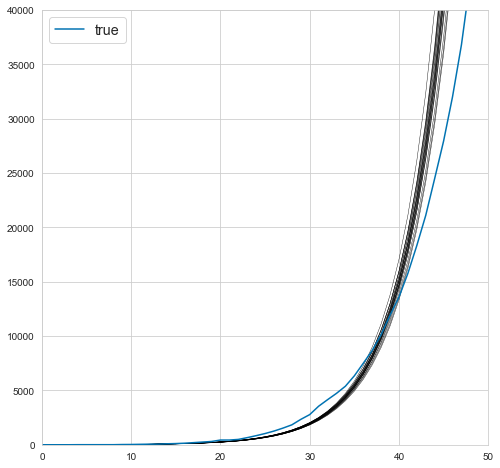

In [91]:
# Только на трейне
plt.figure(figsize = (8,8))
myplot_sample_lines(mu_n, sigma_n, n=20, points=None)
plt.ylim(-0.01,40000)
plt.plot(X_train[:,0],np.exp(y_train), label = 'true')
plt.legend(fontsize = 'x-large')

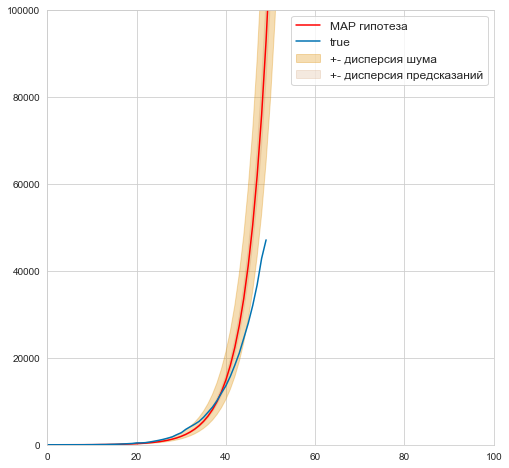

In [94]:
plot_predictions(xs, mu_n, sample_statistics(mu_n, sigma_n, xs, n=1000))
plt.plot(X_train[:,0],np.exp(y_train), label = 'true')
plt.legend(fontsize = 'large')

In [95]:
print('прогноз на 1 мая:', np.exp(linear_regression\
                                  .predict([[(pd.to_datetime('2020-05-01') - pd.to_datetime('2020-03-03')).days]]))[0])
print('прогноз на 1 июнь:', np.exp(linear_regression\
                                  .predict([[(pd.to_datetime('2020-06-01') - pd.to_datetime('2020-03-03')).days]]))[0])
print('прогноз на 1 сентября:', np.exp(linear_regression\
                                  .predict([[(pd.to_datetime('2020-09-01') - pd.to_datetime('2020-03-03')).days]]))[0])

прогноз на 1 мая: 709629.7677139906
прогноз на 1 июнь: 387098703.1967976
прогноз на 1 сентября: 5.1275256962442536e+16


# Задание 3

## Пункт А (Как будем обучать модель сигмоиды?)

Мы пытаемся подогнать набор точек, гауссианой умноженной на константу\
Заметим $(a\Phi_{\mu,\sigma^2}(x))'= $ новые случаи заражения короновирусом за маленький период \
Тем самым мы можем найти апроксимацию через МНК на данных новых случаях заражения для $\Phi(x)'$, а затем перейти за счет куммулятивной суммы к прогнозу число зараженных\
Пусть $y_i = (a\Phi_{\mu,\sigma^2}(x_i))' = \frac{a}{\sqrt{2\pi}\sigma}e^{-(x-\mu)^2/(2\sigma^2)}$\
Перейдем к $\ln y_i$ \
$\ln y_i = \ln a - \ln\sqrt{2\pi}\sigma + \frac{-(x-\mu)^2}{2\sigma^2}$\
$\ln y_i = \ln a - \ln\sqrt{2\pi}\sigma - \frac{x^2}{2\sigma^2} + \frac{x\mu}{\sigma^2} - \frac{\mu^2}{2\sigma^2}$\
Видим, что мы пытаемся предсказать $\ln y$ квадратичным многочленом $w_2 x^2 + w_1 x + w_0$.\

In [96]:
y_train = np.log(train['new_cases']).apply(lambda x: max(x,0))
y_test = np.log(test['new_cases']).apply(lambda x: max(x,0))
X_train = pd.to_datetime(train['date'])-pd.to_datetime('2020-03-03')
X_train = np.array([X_train.apply(lambda x: x.days),X_train.apply(lambda x: x.days ** 2)]).T
X_test = pd.to_datetime(test['date'])-pd.to_datetime('2020-03-03')
X_test = np.array([X_test.apply(lambda x: x.days), X_test.apply(lambda x: x.days ** 2)]).T
X_all = np.concatenate([X_train,X_test], axis = 0)
y_all = np.concatenate([y_train,y_test], axis = 0)

C:\Users\Sali1\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [97]:
linear_regression = LinearRegression().fit(X_train,y_train)

MSE train: 0.6215416799355634
MSE test: 1.0186310290502611


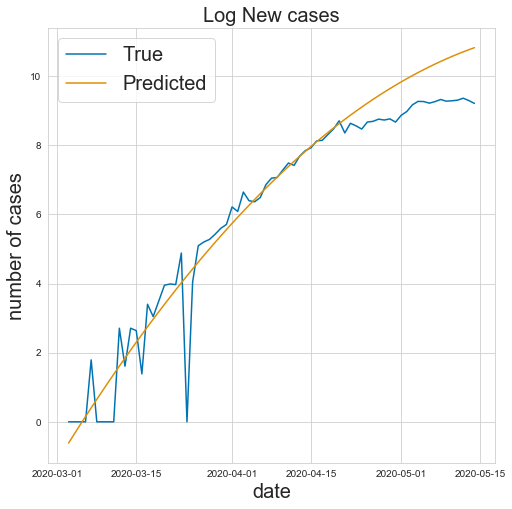

In [98]:
print('MSE train:', mse(linear_regression.predict(X_train),y_train))
print('MSE test:', mse(linear_regression.predict(X_test),y_test))
plt.figure(figsize=(8,8))
plt.title('Log New cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),np.log(Russia['new_cases'].apply(lambda x: max(1,x))), label = 'True')
plt.plot(pd.to_datetime(Russia['date']),linear_regression.predict(X_all), label = 'Predicted')
plt.legend(fontsize = 20);

In [99]:
def com_sum(ar,i):
    s = 0
    for i in range(i):
        s = s + ar[i]
    return s
n = 200
Predicted = linear_regression.predict(np.array([np.arange(200),np.arange(200)**2]).T)
simoid = [com_sum(np.exp(Predicted),i) for i in range(200)]

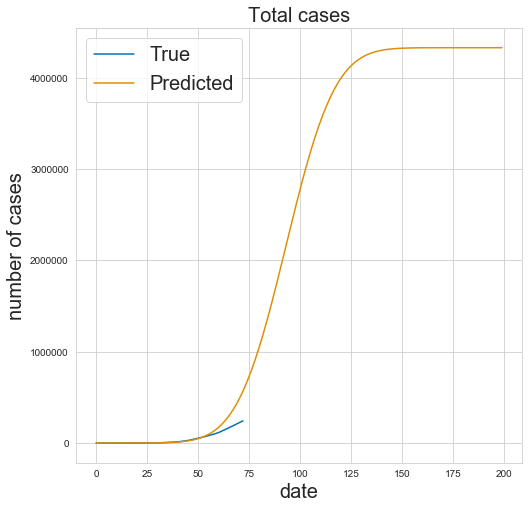

In [100]:
plt.figure(figsize=(8,8))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(np.arange(len(Russia['total_cases'])),Russia['total_cases'], label = 'True');
plt.plot(np.arange(n),simoid, label = 'Predicted')
plt.legend(fontsize = 20);

In [101]:
w_0 = linear_regression.intercept_
w_1 = linear_regression.coef_[0]
w_2 = linear_regression.coef_[1]
sigma = np.sqrt(mse(linear_regression.predict(X_train),y_train))
print('w_0:', w_0)
print('w_1:', w_1)
print('w_2:', w_2)
print('sigma:', sigma)

w_0: -0.6141463702094532
w_1: 0.2598258719977321
w_2: -0.0014019694828364504
sigma: 0.7883791473241561


In [102]:
# априорное распределение параметров w (нормальное с cur_mu и cur_sigma)
cur_mu, cur_sigma = np.array([0, 0, 0]), np.array([[100, 0, 0], [0, 100, 0], [0, 0, 100]])

In [103]:
def bayesian_update(mu, sigma, x, y, sigma_noise = sigma):
    x_matrix = np.array([[1, x, x ** 2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) \
                     * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые экспоненты
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        value = [np.exp(w[0] + w[1]*i + w[2] * (i**2)) for i in xs ]
        com_sum_values = [com_sum(value, i) for i in xs]
        plt.plot(xs, com_sum_values, 'k-', lw=.4)
    plt.ylim((-0.01, 1000000))
    plt.xlim((-0.01, 200))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        value = np.exp(w[0] + w[1]*xs + w[2] * (xs**2))
        com_sum_values = [com_sum(value, j) for j in xs]
        res[i,:] = com_sum_values
    return res

def plot_predictions(xs, mu, x):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((-0.01, 200))
    ax.set_ylim((-0.01, 10000000))
    value = np.exp(mu[0] + mu[1]*xs + mu[2] * (xs**2))
    value_m = np.exp(mu[0] + mu[1]*xs + mu[2] * (xs**2) - sigma)
    value_p = np.exp(mu[0] + mu[1]*xs + mu[2] * (xs**2) + sigma)
    com_sum_values = [com_sum(value, j) for j in xs]
    com_sum_values_m_sigma = [com_sum(value_m, j) for j in xs]
    com_sum_values_p_sigma = [com_sum(value_p, j) for j in xs]
    ax.plot(xs, com_sum_values, color="red", label="MAP гипотеза")
    ax.fill_between(xs, com_sum_values_m_sigma, com_sum_values_p_sigma, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize='small')
    


In [104]:
# сделаем 10 bayes_update
mu_n, sigma_n = cur_mu, cur_sigma
for i in range(10):
    mu_n, sigma_n = bayesian_update(mu_n, sigma_n, X_train[:,0][i],\
                                    y_train.to_numpy()[i])
    
print('mu: \n',mu_n)
print('sigma: \n',sigma_n)

mu: 
 [ 0.24570246 -0.17215941  0.03434537]
sigma: 
 [[ 0.38249607 -0.16025348  0.01405477]
 [-0.16025348  0.10251932 -0.01056084]
 [ 0.01405477 -0.01056084  0.00117404]]


C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


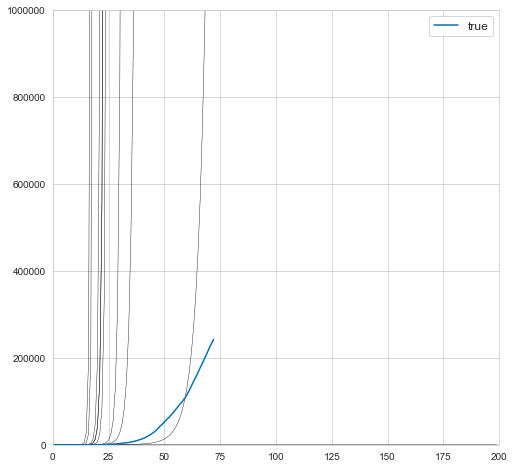

In [105]:
# посемплируем и посмотрим что получется
plt.figure(figsize = (8,8))
myplot_sample_lines(mu_n, sigma_n, n=10, points=None)
plt.plot(np.arange(len(Russia)),Russia['total_cases'], label = 'true')
plt.legend(fontsize = 'large')

C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
C:\Users\Sali1\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
C:\Users\Sali1\anaconda3\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Sali1\anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


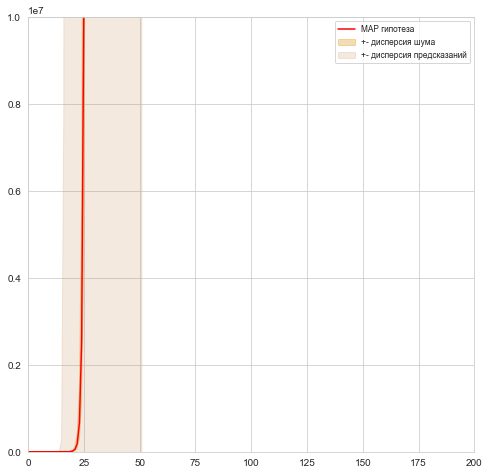

In [106]:
plot_predictions(xs, mu_n, sample_statistics(mu_n, sigma_n, xs, n=100))

In [107]:
mu_n, sigma_n = cur_mu, cur_sigma
for i in range(len(y_train)):
    mu_n, sigma_n = bayesian_update(mu_n, sigma_n, X_train[:,0][i],\
                                    y_train.to_numpy()[i])
    
print('mu: \n',mu_n)
print('sigma: \n',sigma_n)

mu: 
 [-0.61349042  0.25977224 -0.00140106]
sigma: 
 [[ 1.03276568e-01 -8.34414180e-03  1.40473595e-04]
 [-8.34414180e-03  9.20285700e-04 -1.75656408e-05]
 [ 1.40473595e-04 -1.75656408e-05  3.58524605e-07]]


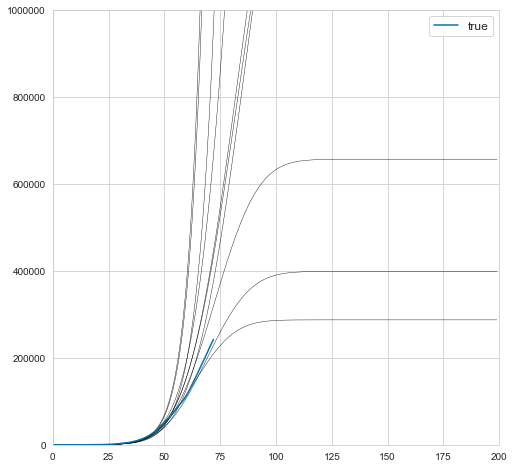

In [108]:
plt.figure(figsize = (8,8))
myplot_sample_lines(mu_n, sigma_n, n=10, points=None)
plt.plot(np.arange(len(Russia)),Russia['total_cases'], label = 'true')
plt.legend(fontsize = 'large')

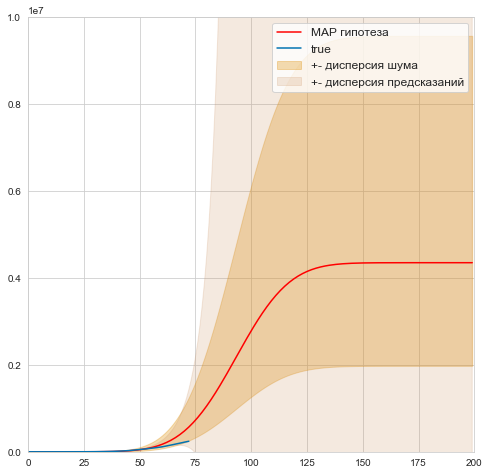

In [109]:
plot_predictions(xs, mu_n, sample_statistics(mu_n, sigma_n, xs, n=100))
plt.plot(np.arange(len(Russia['total_cases'])),Russia['total_cases'], label = 'true')
plt.legend(fontsize = 'large')

In [63]:
China = data[data['location']=='China'][['date','new_cases','total_cases']]

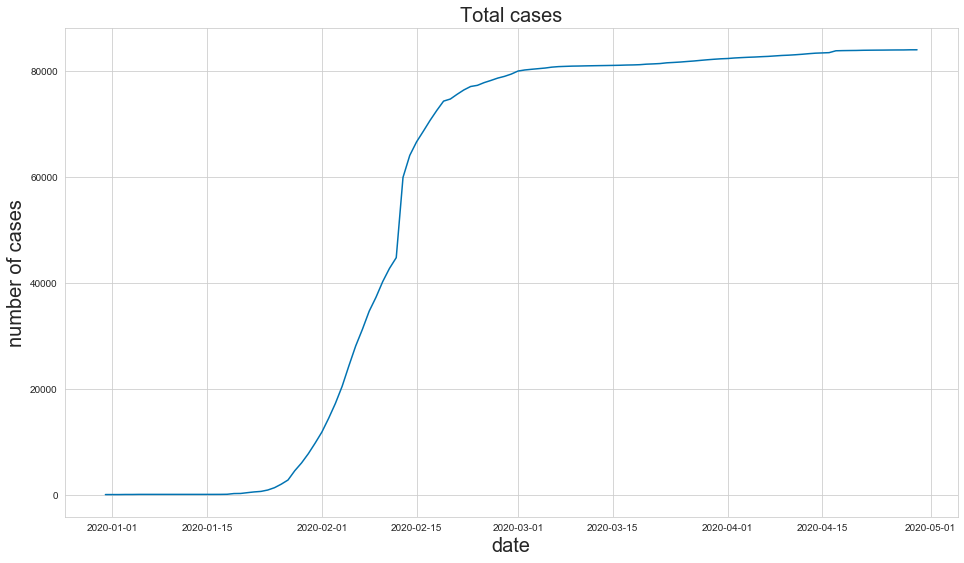

In [64]:
plt.figure(figsize=(16,9))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(China['date']),China['total_cases']);

In [65]:
train = China[:70]
test = China[70:]

In [66]:
y_train = np.log(train['new_cases']).apply(lambda x: max(x,0))
y_test = np.log(test['new_cases']).apply(lambda x: max(x,0))
X_train = pd.to_datetime(train['date'])-pd.to_datetime('2019-12-31')
X_train = np.array([X_train.apply(lambda x: x.days),X_train.apply(lambda x: x.days ** 2)]).T
X_test = pd.to_datetime(test['date'])-pd.to_datetime('2019-12-31')
X_test = np.array([X_test.apply(lambda x: x.days), X_test.apply(lambda x: x.days ** 2)]).T
X_all = np.concatenate([X_train,X_test], axis = 0)
y_all = np.concatenate([y_train,y_test], axis = 0)

C:\Users\Sali1\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [67]:
linear_regression = LinearRegression().fit(X_train,y_train)

MSE train: 2.1425734286826668
MSE test: 165.1114986754117


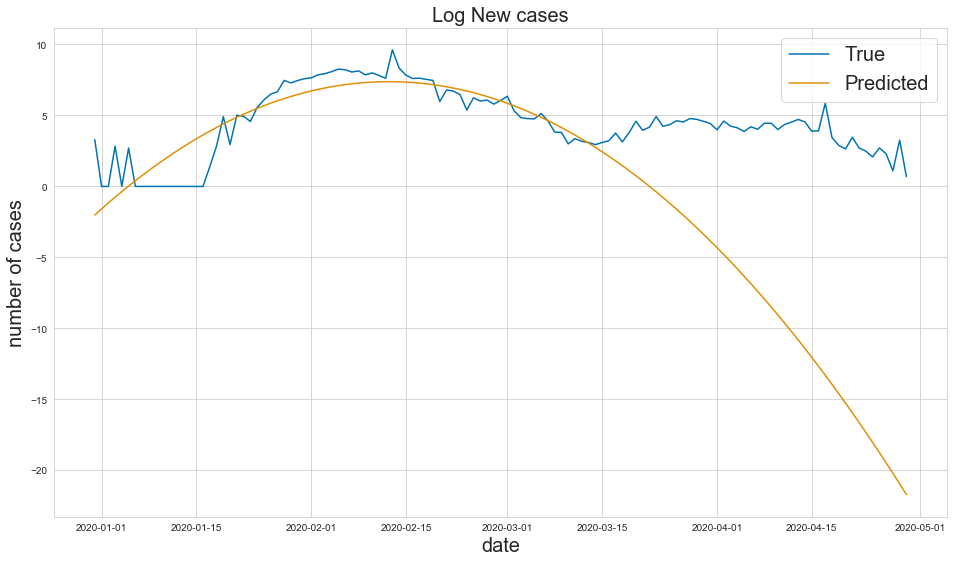

In [68]:
print('MSE train:',mse(linear_regression.predict(X_train),y_train))
print('MSE test:',mse(linear_regression.predict(X_test),y_test))
plt.figure(figsize=(16,9))
plt.title('Log New cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(China['date']),np.log(China['new_cases'].apply(lambda x: max(1,x))), label = 'True')
plt.plot(pd.to_datetime(China['date']),linear_regression.predict(X_all), label = 'Predicted')
plt.legend(fontsize = 20);

In [69]:
n = 100
Predicted = linear_regression.predict(np.array([np.arange(n),np.arange(n)**2]).T)
simoid = [com_sum(np.exp(Predicted),i) for i in range(n)]

In [70]:
China['total_cases']

2460       27
2461       27
2462       27
2463       44
2464       44
        ...  
2576    83899
2577    83909
2578    83912
2579    83938
2580    83940
Name: total_cases, Length: 121, dtype: int64

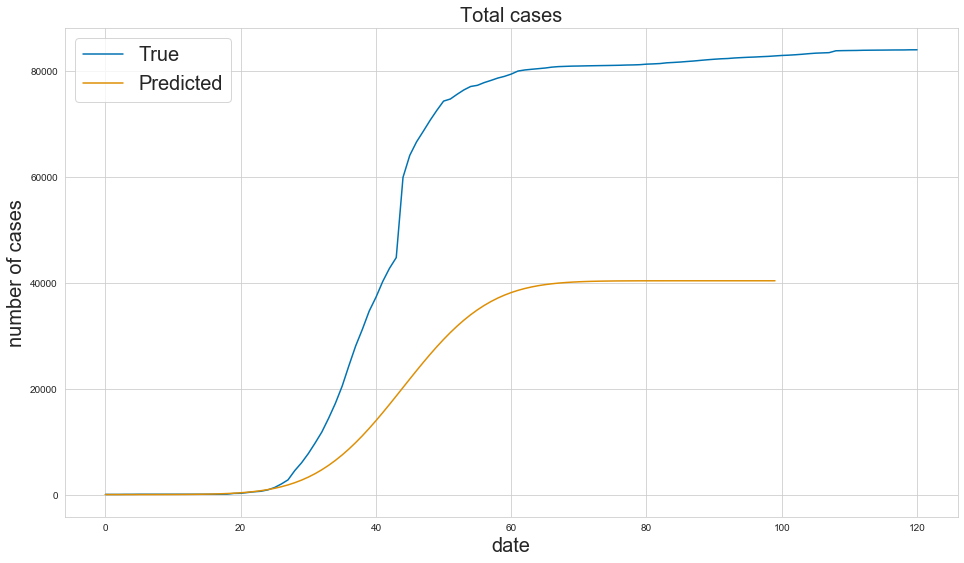

In [71]:
plt.figure(figsize=(16,9))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(np.arange(len(China['total_cases'])),China['total_cases'], label = 'True');
plt.plot(np.arange(n),simoid, label = 'Predicted')
plt.legend(fontsize = 20);